In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import preprocessing
# Machine Learning
from sklearn.model_selection import train_test_split
# -- -- -- -- -- 
import scipy
from scipy import stats
from scipy.stats import trim_mean
from scipy.stats import zscore
# -- -- -- -- --
pd.options.display.max_rows = None

In [2]:
df = pd.read_csv('/Users/jtc/Data_Science_Projects/Medical_Insurance/insurance_ml.csv')

# 8. Machine Learning: Creating a Test Set

- Creating test to avoid overfitting the data.

In [3]:
train_set, test_set = train_test_split(df, test_size = 0.2, random_state = 42)


## 8.1 Stratified Sampling:
- Creating equal sized buckets to represent the data evenly.

In [4]:
df['tier'] = pd.cut(df['charges'],
                   bins=[0.,10000,20000,30000,40000,50000,np.inf],
                   labels=[1,2,3,4,5,6])

## 8.2 Data Visualization: Strata
- Displaying the distributions of each sample from the data.
- e.g 1 represents 10k, 2 represent 20k and so on.

<AxesSubplot:>

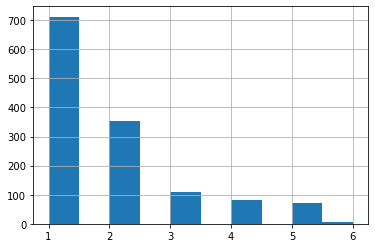

In [5]:
df['tier'].hist()

## 8.3 Creating Copy-set of original Dataframe.

In [6]:
dfc = df.copy()

In [7]:
#StratifiedShuffleSplit

from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(dfc,dfc['tier']):
    strat_train_set = dfc.loc[train_index]
    strat_test_set = dfc.loc[test_index]

## 8.4 Strata Sample Sizes
- Representing the percentages of each labeled range.

In [8]:
strat_test_set['tier'].value_counts() / len(strat_test_set)

1    0.533582
2    0.264925
3    0.082090
4    0.063433
5    0.052239
6    0.003731
Name: tier, dtype: float64

## 8.5 Stripping The Tier Feature
- Removing the feature from the copied DataFrame.

In [9]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("tier", axis = 1, inplace = True)

In [10]:
strat_test_set.head()

,Unnamed: 0,age,sex,bmi,children,smoker,charges
1245,1245,28,1,24.30,5,0,5615.37
775,775,51,1,33.33,3,0,10560.49
1216,1216,40,1,25.08,0,0,5415.66
1332,1332,52,0,44.70,3,0,11411.68
616,616,56,0,28.60,0,0,11658.12


### Creating Copy of the training set

In [11]:
df_sts = strat_train_set.copy()

## 8.6 Trimming the outliers
- RMSE Sensitive to outliers,  removing all values three standard deviations greater or less than the mean.

In [12]:

z_scores = stats.zscore(df_sts)

abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
df_sts = df_sts[filtered_entries]

print(df_sts)


      Unnamed: 0  age  sex    bmi  children  smoker   charges
893          893   47    1  38.94         2       1  44202.65
602          602   56    0  25.30         0       0  11070.54
477          477   25    1  35.62         0       0   2534.39
598          598   43    1  32.60         2       0   7441.50
1075        1075   32    0  29.59         1       0   4562.84
174          174   24    0  33.34         0       0   2855.44
187          187   30    0  30.90         3       0   5325.65
297          297   47    1  25.41         1       1  21978.68
5              5   31    0  25.74         0       0   3756.62
685          685   53    1  26.41         2       0  11244.38
1155        1155   36    0  22.14         3       0   7228.22
354          354   18    0  38.28         0       0  14133.04
561          561   54    0  32.68         0       0  10923.93
1189        1189   23    0  28.00         0       0  13126.68
497          497   45    1  28.70         2       0   8027.97
499     

### 8.6.1 Evaluating Trimmed Mean Change

In [13]:
df_sts.shape

(1050, 7)

## 9. Preparing The Data for ML. ( Clean training set )

- Using Linear Regession Model.

In [14]:
df_sts = strat_train_set.drop('charges', axis = 1)
charges_label = strat_train_set['charges'].copy()

## 9.1 Import Required Libraries ( Scikit-Learn )

In [15]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

lin_reg.fit(df_sts, charges_label)

LinearRegression()

## 9.2 Linear Regression Predictions

In [16]:
some_data = df_sts.iloc[:5]
some_labels = charges_label.iloc[:5]

print("Predictions:", np.round(lin_reg.predict(some_data),2))
print("Labels:", list(some_labels))

Predictions: [37453.37 10886.92  5437.13 10304.9   5025.91]
Labels: [44202.65, 11070.54, 2534.39, 7441.5, 4915.06]


## 9.3 Root Mean Squared Error

In [17]:
from sklearn.metrics import mean_squared_error

charge_predictions = lin_reg.predict(df_sts)
lin_mse = mean_squared_error(charges_label,charge_predictions)
lin_rmse = np.sqrt(lin_mse)
np.round(lin_rmse,2)

6066.52

# 10. Decision Tree Regressor 

In [18]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(df_sts,charges_label)

DecisionTreeRegressor()

## 10.1 Decision Tree Regressor Predictions

In [19]:
tree_predictions = tree_reg.predict(df_sts)
print("Predictions:",tree_predictions)

Predictions: [44202.65 11070.54  2534.39 ... 16297.85  4889.04  3277.16]


## 10.2 Decision Tree Mean Squared Error

In [20]:
tree_mse = mean_squared_error(charges_label, tree_predictions)
tree_mse = np.sqrt(tree_mse)
print(np.round(tree_mse,2))

0.0


# 11.  K-Fold Cross Validation Fine Tune

In [21]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg,
                         df_sts, charges_label,
                         scoring = "neg_mean_squared_error",
                         cv = 10)

tree_rmse_scores = np.sqrt(-scores)

In [22]:
def display_scores(scores):
    print("Scores:" , scores)
    print("Mean:", np.round(scores.mean(),2))
    print("Standard deviation:", np.round(scores.std(),2))
    
display_scores(np.round(tree_rmse_scores,2))

Scores: [7769.52 6744.21 6646.44 6712.33 7299.71 7211.54 7482.96 6762.49 6928.32
 7036.1 ]
Mean: 7059.36
Standard deviation: 355.08


## 11.1 Linear Regression Model K-Fold


In [23]:
lin_scores = cross_val_score(lin_reg,
                             df_sts,
                             charges_label,
                             scoring = "neg_mean_squared_error",
                             cv = 10)
lin_rmse_scores = np.sqrt(-lin_scores)

In [24]:
def display_scores(lin_scores):
    print("Scores:" , lin_scores)
    print("Mean:", np.round(lin_scores.mean(),2))
    print("Standard deviation:", np.round(lin_scores.std(),2))
    
display_scores(np.round(lin_rmse_scores,2))

Scores: [5209.69 6933.17 6426.58 5943.08 6541.44 5830.29 6985.19 4531.53 6161.65
 6102.99]
Mean: 6066.56
Standard deviation: 715.68


# 12. Random Forest

In [25]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators = 100, random_state = 42)

forest_reg.fit(df_sts, charges_label)


RandomForestRegressor(random_state=42)

In [26]:
charges_predictions = forest_reg.predict(df_sts)

forest_mse = mean_squared_error(charges_label, charges_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

1856.9314251378064

In [27]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, 
                                df_sts,
                                charges_label,
                                scoring = 'neg_mean_squared_error',
                                cv = 10)

forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [3969.60195412 5421.71595528 4946.97075129 4688.46779486 5336.87290708
 5122.66574032 5855.4394867  4005.56391998 5116.15640153 4776.82464933]
Mean: 4924.03
Standard deviation: 565.17
